In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/creditcard.csv')

#First inspection of the data

df.head()

In [ ]:
#General analysis of the whole dataset
analysis_general = df.groupby('Class')['Amount'].describe()
print("GENERAL ANALYSIS:")
print(analysis_general)

          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


### Executive Summary: Initial Findings

Our initial dive into the data reveals a clean, well-structured dataset. The core challenge is the severe class imbalance, with fraudulent transactions representing a mere 0.17% of the total. This immediately invalidates accuracy as a performance metric, shifting our focus to the Precision-Recall curve.

A key insight comes from the 'Amount' feature. Fraudulent transactions tell a story of two extremes: a vast majority are for trivial amounts (likely testing cards), punctuated by a few high-value strategic attacks. While legitimate transactions can reach much higher absolute values, their distribution is less polarized.

This distinct behavioral pattern in transaction amounts, combined with the anonymized PCA features, will be the cornerstone of our detection model.

Text(0, 0.5, 'Count')

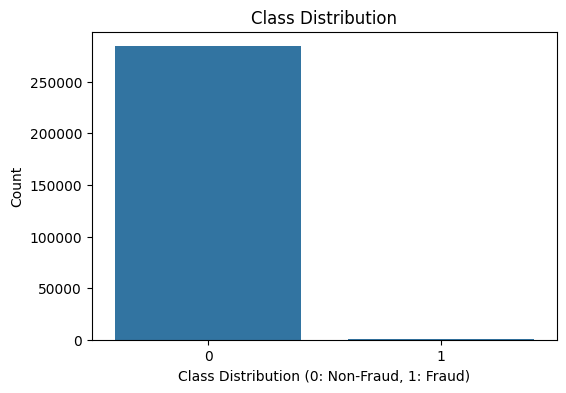

In [16]:
#Visualzation of the class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')

Given the extreme imbalance, accuracy is a deceptive metric. A model that never finds fraud would still be 99.8% "correct," making it useless. Our success, therefore, will be measured by the trade-off between Precision and Recall (AUPRC).

To build an effective model, we must find the subtle signals of fraud. Let's start by analyzing our only non-anonymized features, 'Time' and 'Amount', to see what behavioral patterns they reveal.

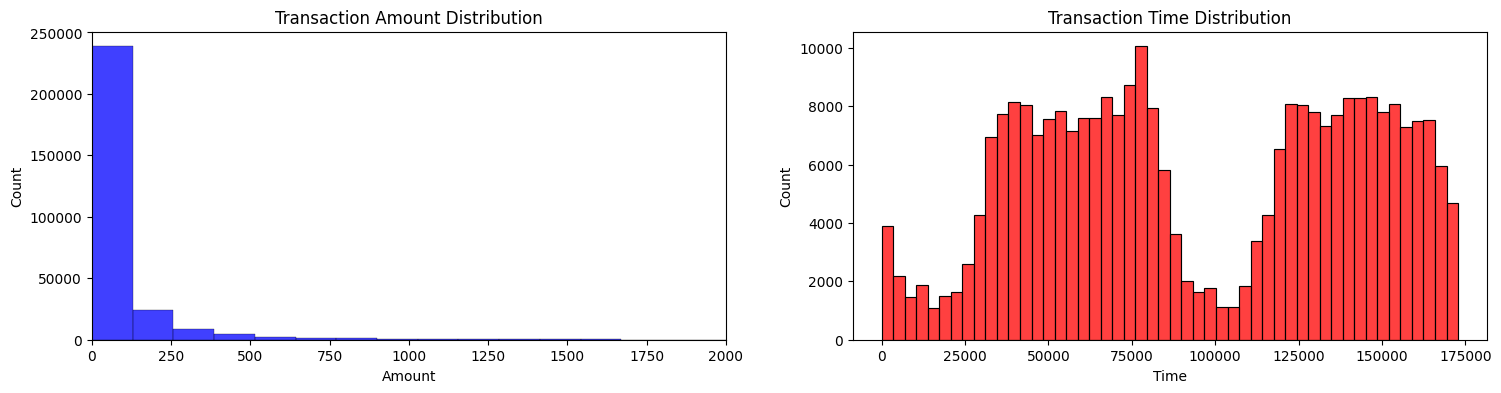

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], bins = 200, ax=ax[0], color = 'b')
ax[0].set_title('Transaction Amount Distribution')
ax[0].set_xlim(0, 2000)

sns.histplot(df['Time'], bins = 50, ax=ax[1], color ='r')
ax[1].set_title('Transaction Time Distribution')
plt.show()

### Observations: Establishing a Baseline

A look at the overall distributions reveals our "normal" activity baseline. The 'Amount' is heavily skewed, confirming that the bulk of transactions are for small, routine purchases. 'Time' exhibits a clear bimodal pattern, almost certainly reflecting the daily ebb and flow of commerce. Let's see the fraudulent transactions

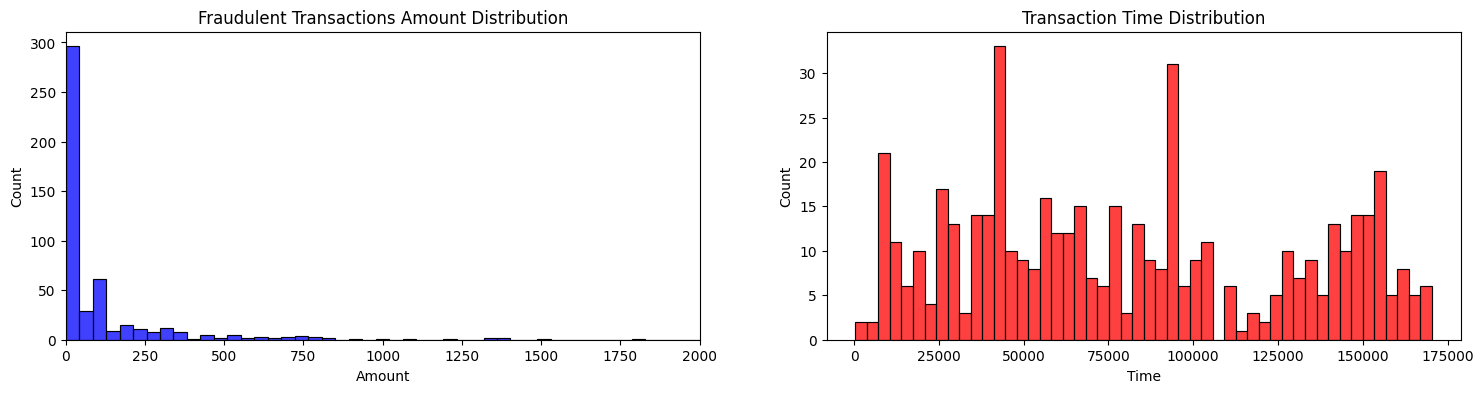

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df[df['Class'] == 1]['Amount'], bins = 50, ax=ax[0], color = 'b')
ax[0].set_title('Fraudulent Transactions Amount Distribution')
ax[0].set_xlim(0, 2000)

sns.histplot(df[df['Class'] == 1]['Time'], bins = 50, ax=ax[1], color ='r')
ax[1].set_title('Transaction Time Distribution')
plt.show()

### Insight: Fraud follows a different time cycle

While legitimate transactions follow a clear diurnal (day/night) cycle, fraudulent activity appears more uniformly spread. This suggests fraudsters may be exploiting off-peak hours when monitoring might be lower. Let's now analyse the outliers.

In [42]:
print("OUTLIER ANALYSIS:")

#Calculate the outliers using the IQR method
Q1_legit = df[df['Class'] == 0]['Amount'].quantile(0.25)
Q3_legit = df[df['Class'] == 0]['Amount'].quantile(0.75)
IQR_legit = Q3_legit - Q1_legit
lim_sup_legit = Q3_legit + 1.5 * IQR_legit
#Inferior limit is not necessary for Amount since it cannot be negative

Q1_fraud = df[df['Class'] == 1]['Amount'].quantile(0.25)
Q3_fraud = df[df['Class'] == 1]['Amount'].quantile(0.75)
IQR_fraud = Q3_fraud - Q1_fraud
lim_sup_fraud = Q3_fraud + 1.5 * IQR_fraud

outliers_legit = df[(df['Class'] == 0) & (df['Amount'] > lim_sup_legit)]
outliers_fraud = df[(df['Class'] == 1) & (df['Amount'] > lim_sup_fraud)]

# These statistics are only from outliers of both classes
print("\n Statistics of Outliers:")
print(f"Upper limit to consider legitimate outlier: {lim_sup_legit:.2f}")
print(f"Number of legitimate outliers: {outliers_legit.shape[0]}")
if not outliers_legit.empty:
    print(f"Mean of legitimate outliers: {outliers_legit['Amount'].mean():.2f}")
    print(f"Median of legitimate outliers: {outliers_legit['Amount'].median():.2f}")
    print(f"Std. Deviation of legitimate outliers: {outliers_legit['Amount'].std():.2f}")

print("\n Statistics of Fraudulent Outliers:")
print(f"Upper limit to consider fraud outlier: {lim_sup_fraud:.2f}")
print(f"Number of fraud outliers: {outliers_fraud.shape[0]}")
if not outliers_fraud.empty:
    print(f"Mean of fraud outliers: {outliers_fraud['Amount'].mean():.2f}")
    print(f"Median of fraud outliers: {outliers_fraud['Amount'].median():.2f}")
    print(f"Std. Deviation of fraud outliers: {outliers_fraud['Amount'].std():.2f}")


OUTLIER ANALYSIS:

 Statistics of Outliers:
Upper limit to consider legitimate outlier: 184.15
Number of legitimate outliers: 31862
Mean of legitimate outliers: 510.90
Median of legitimate outliers: 333.48
Std. Deviation of legitimate outliers: 585.65

 Statistics of Fraudulent Outliers:
Upper limit to consider fraud outlier: 263.23
Number of fraud outliers: 69
Mean of fraud outliers: 625.55
Median of fraud outliers: 512.25
Std. Deviation of fraud outliers: 391.09


Let's complete our analysis with a boxplot diagram for both classes.

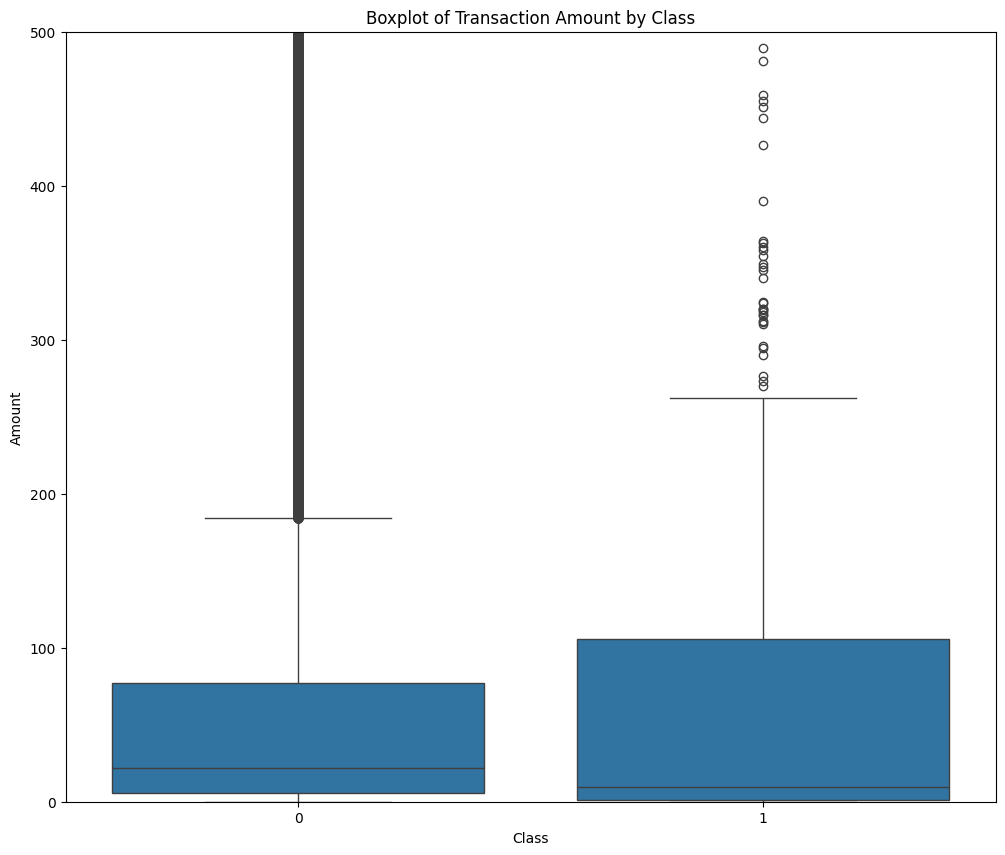

In [43]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df, x='Class', y='Amount')
plt.title('Boxplot of Transaction Amount by Class')
plt.ylim(0, 500)
plt.show()

Analysis reveals a behavioral split between the outlier classes. While high-value legitimate transactions are common, fraudulent outliers, though far less numerous, have a significantly higher average value. This points to a "big hit" strategy.

Furthermore, this aligns with our earlier finding that the overall median for fraudulent transactions is extremely low (around $9). This supports the hypothesis of a polarized distribution: scammers likely use low-value transactions to probe defenses before attempting a large-scale attack.